In [1]:
 !pip install split-folders
# # !pip install tensorboard jupyter ipywidgets

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import drive

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_DIR = "/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images"

In [6]:
import splitfolders
# Split folder into train, test and validation set.
splitfolders.ratio('/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/', output="/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/", seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 5942 files [02:52, 34.40 files/s] 


In [7]:
train_dir = DATASET_DIR + "/train"
valid_dir = DATASET_DIR + "/val"
diseases = os.listdir(train_dir)

diseases = [item for item in diseases if item not in {'train', 'val', 'test'}]

# Print dieases name
print(diseases)

['Bacterialblight', 'Brownspot', 'Blast', 'Tungro']


In [8]:
print(f"Total classes are: {len(diseases)}")

Total classes are: 4


In [9]:
nums = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases}

# Converting the nums dictionary to pandas DataFrame with plant name as index and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])

img_per_class

,No. of images
Bacterialblight,1275
Brownspot,1280
Blast,1152
Tungro,1046


In [10]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
def is_valid_file(file_path):
    try:
        # Open the image file
        with open(file_path, 'rb') as f:
            img = Image.open(f)

            # Attempt to load the image to ensure it's valid
            img.load()
             # Verify the integrity of the image file
            img.verify()
            return True
    except Exception as e:
        # If any exception occurs during the process, consider the file as invalid
        return False


In [12]:
batch_size=32

In [13]:
train_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/train', transform=train_transforms,is_valid_file=is_valid_file)
val_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/val', transform=val_transforms,is_valid_file=is_valid_file)
test_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/test', transform=val_transforms,is_valid_file=is_valid_file)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

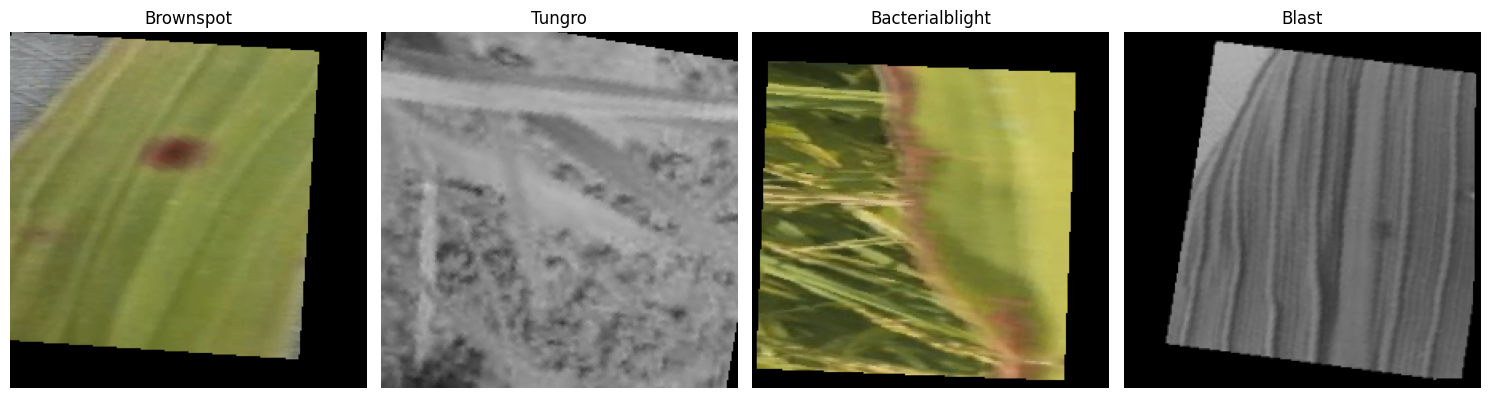

In [15]:
unique_classes = set()
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
num_cols = min(5, num_classes)
num_rows = math.ceil(num_classes / num_cols)

if num_rows == 1:
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15, 5))
else:
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

row_index = 0
col_index = 0

for images, labels in train_loader:
    for image, label in zip(images, labels):
        class_name = idx_to_class[label.item()]
        if class_name not in unique_classes:
            unique_classes.add(class_name)
            if num_rows == 1:
                ax = axes[col_index]
            else:
                ax = axes[row_index, col_index]
            img = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')

            col_index += 1
            if col_index == num_cols:
                col_index = 0
                row_index += 1

        if len(unique_classes) == num_classes:
            break
    if len(unique_classes) == num_classes:
        break

plt.tight_layout()
plt.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.vgg19(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Dropout(0.7),  # Increased dropout rate
#     nn.Linear(num_ftrs, len(train_dataset.classes))
# )
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)
model.to(device)




Device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 192MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [18]:
TENSORBOARD_SUMMARY_PATH=f'{DATASET_DIR}/Rice_Leaf_Disease_Images'
writer = SummaryWriter(TENSORBOARD_SUMMARY_PATH)

In [19]:
BEST_MODEL_PATH='/content/drive/MyDrive/Rice_Leaf_Disease_Images.pth'

In [20]:
early_stopping_patience = 5
epochs_no_improve = 0
val_loss_min = np.Inf

In [21]:
def train_model(num_epochs):
    global epochs_no_improve
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        writer.add_scalar('Training loss', epoch_loss, epoch)
        writer.add_scalar('Training accuracy', epoch_acc, epoch)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / val_total
        val_accuracy = val_correct / val_total
        writer.add_scalar('Validation loss', val_loss, epoch)
        writer.add_scalar('Validation accuracy', val_accuracy, epoch)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == early_stopping_patience:
            print('Early stopping initiated...')
            break

In [22]:
num_epochs = 10
train_model(num_epochs)

Epoch [1/10], Train Loss: 0.7826, Train Acc: 0.6745, Val Loss: 0.2505, Val Acc: 0.8922
Epoch [2/10], Train Loss: 0.3651, Train Acc: 0.8695, Val Loss: 0.1952, Val Acc: 0.9414
Epoch [3/10], Train Loss: 0.2913, Train Acc: 0.8969, Val Loss: 0.0375, Val Acc: 0.9830
Epoch [4/10], Train Loss: 0.2221, Train Acc: 0.9195, Val Loss: 0.0248, Val Acc: 0.9943
Epoch [5/10], Train Loss: 0.1927, Train Acc: 0.9290, Val Loss: 0.0081, Val Acc: 1.0000
Epoch [6/10], Train Loss: 0.1524, Train Acc: 0.9467, Val Loss: 0.0119, Val Acc: 0.9981
Epoch [7/10], Train Loss: 0.1434, Train Acc: 0.9476, Val Loss: 0.0075, Val Acc: 0.9981
Epoch [8/10], Train Loss: 0.1443, Train Acc: 0.9523, Val Loss: 0.0121, Val Acc: 1.0000
Epoch [9/10], Train Loss: 0.1136, Train Acc: 0.9578, Val Loss: 0.0043, Val Acc: 0.9981
Epoch [10/10], Train Loss: 0.1324, Train Acc: 0.9495, Val Loss: 0.0016, Val Acc: 1.0000


In [23]:
# Model evaluation
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_correct = 0
test_total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.4f}')

writer.close()



Test Accuracy: 1.0000


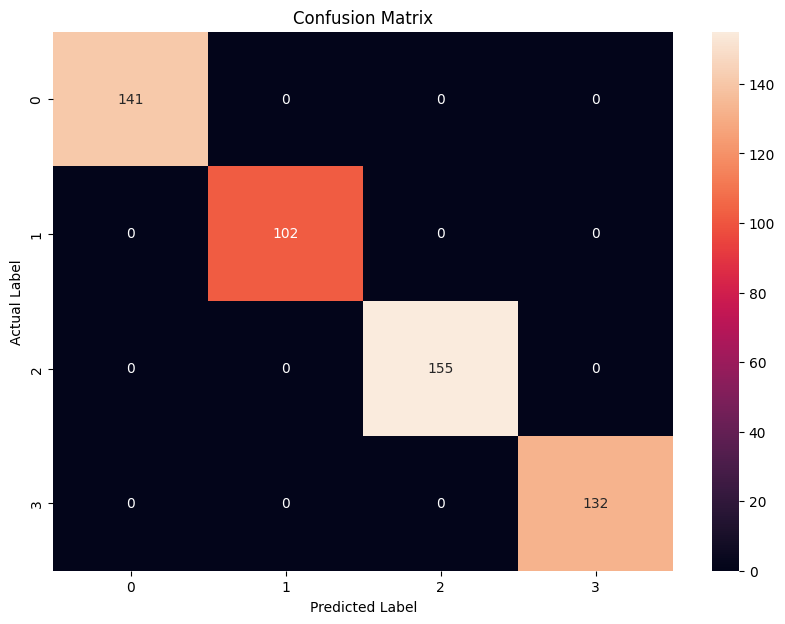

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00       102
           2       1.00      1.00      1.00       155
           3       1.00      1.00      1.00       132

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



In [24]:
conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)

In [25]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'train_loss' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
def extract_features(loader, model, device):
    features = []
    targets = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)